In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df=pd.read_csv("online_retail.csv")

In [24]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [25]:
# Drop null CustomerIDs
df = df.dropna(subset=['CustomerID'])

# Remove canceled/returned transactions (Quantity < 0)
df = df[df['Quantity'] > 0]

# Add 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [26]:
import datetime as dt

NOW = dt.datetime(2011, 12, 10)  # Based on data's latest date


In [27]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


rfm table

In [28]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})




In [29]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


In [30]:
def segment(row):
    if row['RFM_Score'] == '444':
        return 'Champions'
    elif row['R'] == 4 and row['F'] >= 3:
        return 'Loyal Customers'
    elif row['R'] >= 3 and row['M'] >= 3:
        return 'Potential Loyalist'
    elif row['R'] == 1:
        return 'Churned'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)


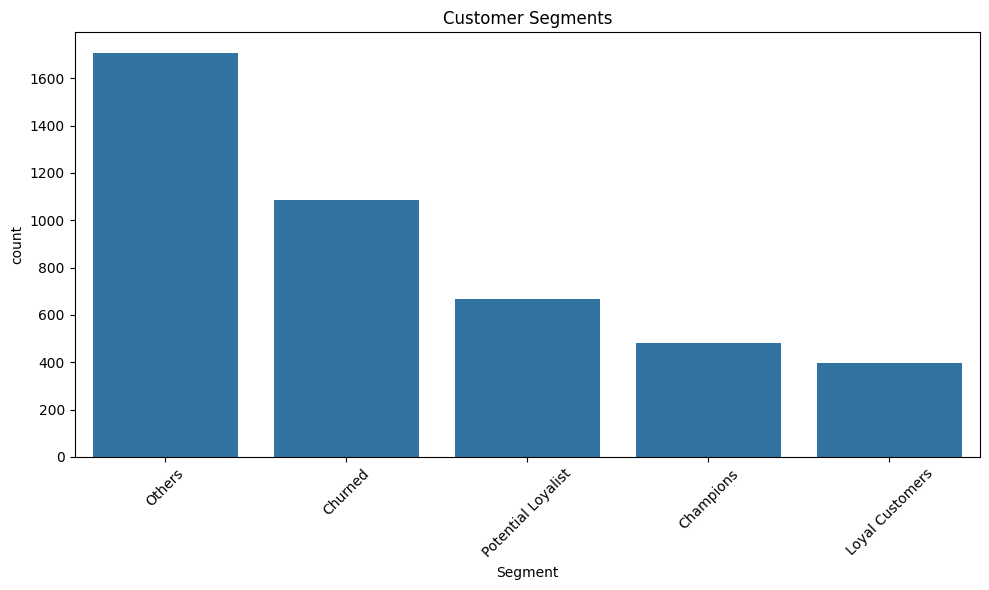

<Figure size 640x480 with 0 Axes>

In [31]:

plt.figure(figsize=(10,6))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.savefig('rfm_Bar.png')

| Segment                | Meaning                                                                  |
| ---------------------- | ------------------------------------------------------------------------ |
| **Others**             | Customers who don’t fit clearly into other categories (likely mid-tier). |
| **Churned**            | Previously active but no recent purchases (low Recency).                 |
| **Potential Loyalist** | Recent & frequent buyers, might become loyal.                            |
| **Champions**          | Best customers — frequent, recent, and high spenders.                    |
| **Loyal Customers**    | Regular buyers, high frequency, medium recency.                          |


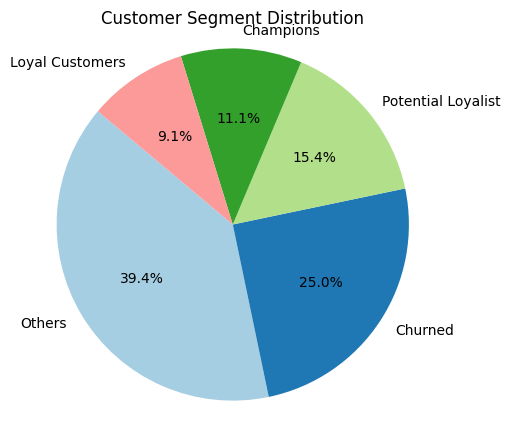

<Figure size 640x480 with 0 Axes>

In [32]:


# Count of each segment
segment_counts = rfm['Segment'].value_counts()

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segment Distribution')
plt.axis('equal')  # Makes the pie circular
plt.show()

plt.savefig('rfm_PIE.png')


In [33]:
rfm.to_csv("RFM_Customer_Segments.csv")


kmeans clustering 


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [35]:
# Assuming rfm_df is already computed
rfm_df = pd.read_csv("RFM_Customer_Segments.csv") # Or use your RFM table DataFrame
rfm = rfm_df[['Recency', 'Frequency', 'Monetary']]


In [36]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


elbow method------

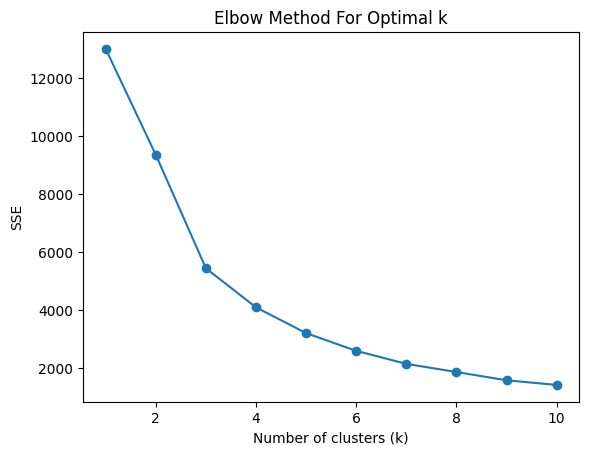

<Figure size 640x480 with 0 Axes>

In [37]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()


plt.savefig('elbowMEthod.png')


In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


C:\Users\brdrv\AppData\Local\Temp\ipykernel_26752\3737514133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


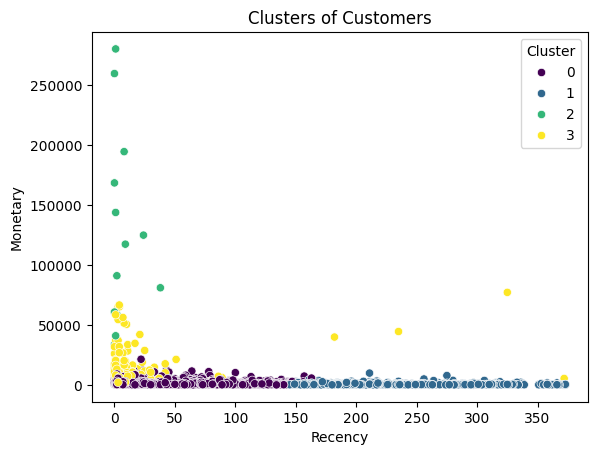

<Figure size 640x480 with 0 Axes>

In [39]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title("Clusters of Customers")
plt.show()


plt.savefig('rfm_clusters.png')


In [40]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={"Cluster": "Count"}).reset_index()

print(cluster_summary)


   Cluster     Recency  Frequency       Monetary  Count
0        0   43.477079   3.655206    1349.382627   3054
1        1  248.173421   1.551367     478.194732   1061
2        2    6.615385  82.692308  127338.313846     13
3        3   15.123223  22.047393   12453.225924    211
